In [1]:
from utils.calculation_helpers import *
#
from utils.drone_utils import *
from utils.map_engine import *
from utils.map_folium import *
from utils.map_helpers import *
from utils.qt_utils import *
from pprint import pprint
import numpy as np
from shapely.geometry import LineString, Polygon, Point
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
# Load the area from the file
points_from_file = []
with open('./logs/area/current_area.txt') as file:
    data = file.read().strip().split("\n")
    for line in data:
        lat, lon = line.split(",")
        points_from_file.append([float(lat), float(lon)])
points_from_file 

[[21.059709, 105.798769],
 [21.059909, 105.785916],
 [21.065677, 105.783126],
 [21.070264, 105.790701],
 [21.066058, 105.803447],
 [21.059709, 105.798769]]

[(1625.058470013293, 0.0),
 (289.83654881453106, 22.263898158602828),
 (0.0, 664.3547210541795),
 (786.9218125766545, 1174.9772253230128),
 (2111.0281378288446, 706.7674470465117),
 (1625.058470013293, 0.0)]
True


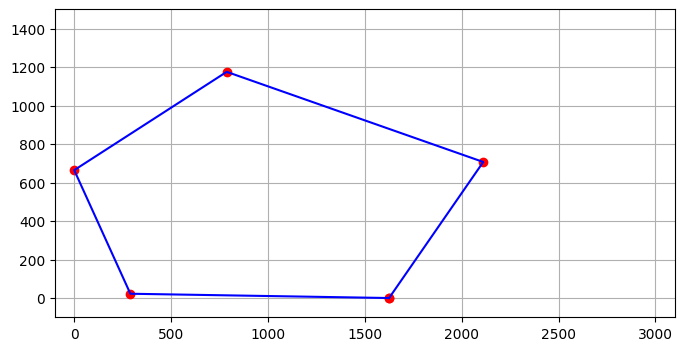

In [3]:
# Convert the points to cartesian coordinates
cartesian_coordinates = convert_to_cartesian(points_from_file)
pprint(cartesian_coordinates)
print(is_polygon_convex(cartesian_coordinates))
# plot polygon
plt.figure(figsize=(8,4))
plt.xlim(-100, 3100)
plt.ylim(-100, 1500)

plt.plot([x[0] for x in cartesian_coordinates], [x[1] for x in cartesian_coordinates], 'ro')
plt.plot([x[0] for x in cartesian_coordinates] + [cartesian_coordinates[0][0]], [x[1] for x in cartesian_coordinates] + [cartesian_coordinates[0][1]], 'b-')
plt.grid()

Longest edge points:  ((786.9218125766545, 1174.9772253230128), (2111.0281378288446, 706.7674470465117))
Main perpendicular line:  (2.828019376541598, -3156.8569698124957)
Intersection points of perpendicular line:  [[1119.2606470327828, 8.433827396700508], [1448.9749752027496, 940.8723361847624]]
Parallel lines to longest edge:  [(-0.35360436646756854, 614.0146663859849), (-0.35360436646756843, 823.8200533691613), (-0.35360436646756827, 1033.6254403523378), (-0.35360436646756843, 1243.4308273355146)]
Intersection points of parallel lines:  [[[27.03909753868902, 604.453523430962], [1646.8438702369463, 31.68348297985085]], [[159.06920040570444, 767.5724895351996], [1762.889937134921, 200.45447399651607]], [[368.3534044626877, 903.3740681311372], [1878.9360040328957, 369.2254650131814]], [[577.6376085196711, 1039.175646727075], [1994.9820709308701, 537.9964560298465]]]


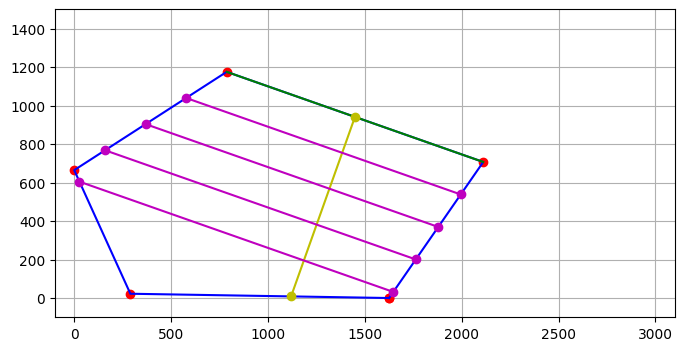

In [4]:
number_of_parts = 5
vertices = points_from_file
split_areas = []
# Convert the list of positions to a NumPy array
points = np.array(vertices)

cartesian_coordinates = convert_to_cartesian(points)

# 1. Find longest edge
longest_edge_points = find_longest_edge(cartesian_coordinates)
print("Longest edge points: ", longest_edge_points)
# 2. Find the perpendicular line to the longest edge at midpoint
main_perpendicular_line = perpendicular_lines_at_points(longest_edge_points, N=2)[0]
print("Main perpendicular line: ", main_perpendicular_line)
intersection_pts_of_perpendicular_line = find_polygon_line_intersections(
    cartesian_polygon=cartesian_coordinates, line=main_perpendicular_line
)
print("Intersection points of perpendicular line: ", intersection_pts_of_perpendicular_line)
perp_line_within_polygon = intersection_pts_of_perpendicular_line
# 3. Divide the perpendicular line into equal parts, and find the lines parallel to the longest edge
parallel_lines_to_longest_edge = perpendicular_lines_at_points(
    perp_line_within_polygon, N=number_of_parts
)
parallel_lines_to_longest_edge.sort(key=lambda x: x[1])  
print("Parallel lines to longest edge: ", parallel_lines_to_longest_edge)
# 4. Find the intersection points of the parallel lines with the polygon
intersection_pts_of_parallel_lines = [
    find_polygon_line_intersections(cartesian_coordinates, line)
    for line in parallel_lines_to_longest_edge
]
print("Intersection points of parallel lines: ", intersection_pts_of_parallel_lines)

# plot 
plt.figure(figsize=(8,4))
plt.xlim(-100, 3100)
plt.ylim(-100, 1500)

plt.plot([x[0] for x in cartesian_coordinates], [x[1] for x in cartesian_coordinates], 'ro')
plt.plot([x[0] for x in cartesian_coordinates] + [cartesian_coordinates[0][0]], [x[1] for x in cartesian_coordinates] + [cartesian_coordinates[0][1]], 'b-')

plt.plot([x[0] for x in longest_edge_points], [x[1] for x in longest_edge_points], 'g-')

plt.plot([x[0] for x in intersection_pts_of_perpendicular_line], [x[1] for x in intersection_pts_of_perpendicular_line], 'yo')
plt.plot([x[0] for x in intersection_pts_of_perpendicular_line], [x[1] for x in intersection_pts_of_perpendicular_line], 'y-')

for points in intersection_pts_of_parallel_lines:
    plt.plot([x[0] for x in points], [x[1] for x in points], 'mo')
    plt.plot([x[0] for x in points], [x[1] for x in points], 'm-')
    
plt.grid()

In [6]:
results = split_polygon_into_areas(points_from_file, number_of_parts)
pprint(results)

{'cartesian': {0: [(1625.058470013293, 0.0),
                   (289.83654881453106, 22.263898158602828),
                   [27.03909753868902, 604.453523430962],
                   [1646.8438702369463, 31.68348297985085]],
               1: [(0.0, 664.3547210541795),
                   [27.03909753868902, 604.453523430962],
                   [1646.8438702369463, 31.68348297985085],
                   [159.06920040570444, 767.5724895351996],
                   [1762.889937134921, 200.45447399651607]],
               2: [[159.06920040570444, 767.5724895351996],
                   [1762.889937134921, 200.45447399651607],
                   [368.3534044626877, 903.3740681311372],
                   [1878.9360040328957, 369.2254650131814]],
               3: [[368.3534044626877, 903.3740681311372],
                   [1878.9360040328957, 369.2254650131814],
                   [577.6376085196711, 1039.175646727075],
                   [1994.9820709308701, 537.9964560298465]],
            

In [7]:
def find_longest_edge2(cartesian_coords):
    """
    Find the vertices that form the longest edge in a polygon given its vertices in Cartesian coordinates.

    :param cartesian_coords: A list of tuples (x, y) representing the Cartesian coordinates of the polygon vertices.
    :return: A tuple containing:
        - the length of the longest edge,
        - the coordinates of the start vertex of the longest edge,
        - the coordinates of the end vertex of the longest edge.
    """
    num_vertices = len(cartesian_coords)
    longest_edge_length = 0
    longest_edge_vertices = (None, None)

    for i in range(num_vertices):
        # Current vertex
        x1, y1 = cartesian_coords[i]
        # Next vertex, with wrap-around using modulo to close the polygon
        x2, y2 = cartesian_coords[(i + 1) % num_vertices]

        # Calculate the distance between the current vertex and the next vertex
        distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        # Check if this is the longest edge found so far
        if distance > longest_edge_length:
            longest_edge_length = distance
            longest_edge_vertices = ((x1, y1), (x2, y2))

    return longest_edge_length, longest_edge_vertices

def find_midpoint(point1, point2):
    # Extract coordinates from the points
    x1, y1 = point1
    x2, y2 = point2

    # Calculate the midpoint coordinates
    mid_x = (x1 + x2) / 2.0
    mid_y = (y1 + y2) / 2.0

    return (mid_x, mid_y)

def line_equation_from_points(p1, p2):
    x1, y1 = p1
    x2, y2 = p2

    # Check for vertical line
    if x1 == x2:
        # The line is vertical, slope is undefined, and the line equation is x = x1
        return None, x1

    # Check for horizontal line
    elif y1 == y2:
        # The line is horizontal, slope is 0, and the line equation is y = y1
        return 0, y1

    else:
        # For non-vertical and non-horizontal lines, calculate slope and intercept
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        return slope, intercept


def angle_with_x_axis(slope):
    if slope is None:  # Vertical line
        angle_degrees = 90
    else:
        angle_radians = math.atan(slope)
        angle_degrees = math.degrees(angle_radians)

    return angle_degrees


def perpendicular_line_equation(midpoint, slope, tolerance=1e-6):
    """
    Calculate the slope and y-intercept of the line perpendicular to the line with the given slope,
    passing through the given midpoint.

    :param midpoint: A tuple (x, y) representing the midpoint through which the perpendicular line passes.
    :param slope: The slope of the original line. Can be a number, zero, or None for vertical lines.
    :param tolerance: The tolerance range for slope comparisons to account for floating-point inaccuracies.
    :return: A tuple (perpendicular slope, y-intercept) representing the perpendicular line.
             Returns (None, y-coordinate of midpoint) for vertical lines and
             (0, x-coordinate of midpoint) for horizontal lines.
    """
    mx, my = midpoint

    # Check if the original slope is near zero (horizontal line)
    if slope is not None:
        if -tolerance < slope < tolerance:
            # The perpendicular line would be vertical
            return None, my

    # Check if the original slope is undefined (vertical line)
    elif slope is None:
        # The perpendicular line would be horizontal
        return 0, my

    # Otherwise, calculate the perpendicular slope and intercept
    perp_slope = -1 / slope
    perp_intercept = my - perp_slope * mx
    return perp_slope, perp_intercept


def calculate_new_lat_lon(origin_lat, origin_lon, distance_north, distance_east):
    """Calculate new latitude and longitude from origin given distances north and east."""
    R = 6378000  # Radius of Earth in meters
    delta_lat = distance_north / R  # Change in latitude in radians
    new_lat = origin_lat + math.degrees(delta_lat)  # New latitude in degrees

    # Adjust for change in longitude, which depends on latitude
    r = R * math.cos(math.radians(new_lat))  # Effective radius at new latitude
    delta_lon = distance_east / r  # Change in longitude in radians
    new_lon = origin_lon + math.degrees(delta_lon)  # New longitude in degrees

    return (new_lat, new_lon)


def divide_line_into_segments(x1, y1, x2, y2, n):
    points = []
    # We skip 0 and n because they correspond to the endpoints.
    for i in range(1, n):
        t = i / n
        xt = (1 - t) * x1 + t * x2
        yt = (1 - t) * y1 + t * y2
        points.append((xt, yt))

    return points


def perpendicular_line_intersect_polygon(slope, intercept, vertices):
    across_points = []
    for i in range(len(vertices)):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % len(vertices)]

        # Check if the edge is vertical
        if x1 == x2:
            if slope is None:
                # Both the line and edge are vertical, so check if they are the same line
                if x1 == intercept:  # Using intercept as x since the line is vertical
                    # Overlapping vertical lines intersect at any point along their span
                    overlap_range = [max(min(y1, y2), intercept), min(max(y1, y2), intercept)]
                    if overlap_range[0] != overlap_range[1]:
                        # Return a representative point from the overlapping segment
                        point = (x1, sum(overlap_range) / 2)
                        across_points.append(point)
            else:
                # The edge is vertical while the line is not, calculate y using line's equation
                intersect_y = slope * x1 + intercept
                if min(y1, y2) <= intersect_y <= max(y1, y2):
                    point = (x1, intersect_y)
                    across_points.append(point)

        # Check if the edge is non-vertical
        elif x2 != x1:
            m_e = (y2 - y1) / (x2 - x1)
            b_e = y1 - m_e * x1
            if slope is None:
                # The line is vertical, calculate x using edge's equation
                intersect_x = intercept  # Using intercept as x since the line is vertical
                intersect_y = m_e * intercept + b_e
                if min(x1, x2) <= intersect_x <= max(x1, x2):
                    point = (intersect_x, intersect_y)
                    across_points.append(point)
            elif slope != m_e:
                # Ensure the lines are not parallel and calculate the intersection
                intersect_x = (b_e - intercept) / (slope - m_e)
                intersect_y = slope * intersect_x + intercept
                if min(x1, x2) <= intersect_x <= max(x1, x2) and min(y1, y2) <= intersect_y <= max(
                    y1, y2
                ):
                    point = (intersect_x, intersect_y)
                    across_points.append(point)

    return across_points


def divide_points(per_points, polygon, slope1, edge_slope):
    each_point = []
    for point in per_points:
        perp_slope, perp_intercept = perpendicular_line_equation(point, slope1)
        per_dot = perpendicular_line_intersect_polygon(perp_slope, perp_intercept, polygon)

        each_point.extend(per_dot)

    return each_point


def rotate_and_shift_point(
    x, y, angle, pivot_x, pivot_y, shift_x=0, shift_y=0, units="DEGREES", clockwise=False
):
    """
    Rotates a point around a pivot point either clockwise or counterclockwise and then applies a shift.

    :param x: The x-coordinate of the point to be rotated.
    :param y: The y-coordinate of the point to be rotated.
    :param angle: The angle of rotation. Positive angles will result in counterclockwise rotation,
                  and negative angles will result in clockwise rotation if `clockwise` is set to True.
    :param pivot_x: The x-coordinate of the pivot point.
    :param pivot_y: The y-coordinate of the pivot point.
    :param shift_x: The distance to shift along the x-axis after rotation.
    :param shift_y: The distance to shift along the y-axis after rotation.
    :param units: The units of the angle: 'DEGREES' (default) or 'RADIANS'.
    :param clockwise: If True, the rotation will be clockwise, otherwise counterclockwise.
    :return: A tuple containing the rotated and shifted x and y coordinates.
    """

    # Convert angle from degrees to radians if specified in degrees
    if units.upper() == "DEGREES":
        angle = math.radians(angle)

    # If clockwise rotation is desired, negate the angle
    if clockwise:
        angle = -angle

    # Translate point to pivot
    x -= pivot_x
    y -= pivot_y

    # Apply rotation
    cos_theta = math.cos(angle)
    sin_theta = math.sin(angle)
    x_rotated = (x * cos_theta) - (y * sin_theta)
    y_rotated = (x * sin_theta) + (y * cos_theta)

    # Translate point back from pivot and apply additional shift
    x_final = x_rotated + pivot_x + shift_x
    y_final = y_rotated + pivot_y + shift_y

    return x_final, y_final


def revert_rotate_and_shift_point(
    x, y, angle, pivot_x, pivot_y, shift_x=0, shift_y=0, units="DEGREES", clockwise=False
):
    """
    Reverts the rotation and shift applied to a point. First subtracts the shift, then rotates the point back.

    :param x: The x-coordinate of the point that was rotated and shifted.
    :param y: The y-coordinate of the point that was rotated and shifted.
    :param angle: The original angle of rotation used to rotate the point.
    :param pivot_x: The x-coordinate of the pivot point used in the original rotation.
    :param pivot_y: The y-coordinate of the pivot point used in the original rotation.
    :param shift_x: The x-distance of the shift to revert.
    :param shift_y: The y-distance of the shift to revert.
    :param units: The units of the angle: 'DEGREES' (default) or 'RADIANS'.
    :param clockwise: If the original rotation was clockwise, set True; otherwise, set False.
    :return: A tuple containing the x and y coordinates of the point after reverting the rotation and shift.
    """

    # Subtract the shift
    x -= shift_x
    y -= shift_y

    # Convert angle from degrees to radians if specified in degrees
    if units.upper() == "DEGREES":
        angle = math.radians(angle)

    # Reverse the angle direction for the rotation back
    if not clockwise:
        angle = -angle

    # Translate point to pivot
    x -= pivot_x
    y -= pivot_y

    # Apply rotation in the opposite direction
    cos_theta = math.cos(angle)
    sin_theta = math.sin(angle)
    x_reverted = (x * cos_theta) + (y * sin_theta)
    y_reverted = (-x * sin_theta) + (y * cos_theta)

    # Translate point back from pivot
    x_final = x_reverted + pivot_x
    y_final = y_reverted + pivot_y

    return x_final, y_final


def does_line_intersect_polygon(mid, slope, intercept, vertices, tolerance=1e-6):
    for i in range(len(vertices)):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % len(vertices)]

        # Check for vertical edge (x1 == x2)
        if x1 == x2:
            if slope is None:  # The line is also vertical, check if they are the same line
                if abs(x1 - mid[0]) <= tolerance:  # The line coincides with the edge
                    continue
                else:  # Parallel lines, no intersection
                    return None
            else:
                intersect_x = x1
                intersect_y = slope * intersect_x + intercept
                if min(y1, y2) <= intersect_y <= max(y1, y2) and \
                   abs(intersect_x - mid[0]) > tolerance and abs(intersect_y - mid[1]) > tolerance:
                    return intersect_x, intersect_y

        else:  # Non-vertical edge
            edge_slope = (y2 - y1) / (x2 - x1)
            edge_intercept = y1 - edge_slope * x1

            # The line is vertical, use its x-intercept (which is actually the x coordinate)
            if slope is None:
                intersect_x = intercept
                intersect_y = edge_slope * intersect_x + edge_intercept
                if min(x1, x2) <= intersect_x <= max(x1, x2) and \
                   abs(intersect_y - mid[1]) > tolerance:
                    return intersect_x, intersect_y

            elif slope != edge_slope:  # The line is not vertical and not parallel to the edge
                intersect_x = (edge_intercept - intercept) / \
                    (slope - edge_slope)
                intersect_y = slope * intersect_x + intercept

                if min(x1, x2) <= intersect_x <= max(x1, x2) and min(y1, y2) <= intersect_y <= max(y1, y2) and \
                   (abs(intersect_x - mid[0]) > tolerance or abs(intersect_y - mid[1]) > tolerance):
                    return intersect_x, intersect_y
    return None


def split_area(area, perp, tolerance=1e-6):
    area_list = []

    # Helper function to check if y is approximately less than or equal to perp_y
    def y_leq_with_tolerance(y, perp_y):
        return abs(y) <= abs(perp_y) + tolerance

    # Helper function to check if y is approximately greater than or equal to perp_y
    def y_geq_with_tolerance(y, perp_y):
        return abs(y) >= abs(perp_y) - tolerance

    # Case when only one perpendicular point is provided
    if len(perp) == 1:
        below_or_equal, above_or_equal = [], []
        perp_y = perp[0][1]

        for point in area:
            if y_leq_with_tolerance(point[1], perp_y):
                below_or_equal.append(point)
            if y_geq_with_tolerance(point[1], perp_y):
                above_or_equal.append(point)

        area_list.append(below_or_equal)
        area_list.append(above_or_equal)

    # Case when more than one perpendicular point is provided
    else:
        for i, perp_point in enumerate(perp):
            one_area = []
            perp_y = perp_point[1]

            if i == 0:
                for point in area:
                    if y_leq_with_tolerance(point[1], perp_y):
                        one_area.append(point)

            elif i == len(perp) - 1:
                previous_perp_y = perp[i - 1][1]
                for point in area:
                    if y_geq_with_tolerance(point[1], previous_perp_y) and y_leq_with_tolerance(point[1], perp_y):
                        one_area.append(point)
                area_list.append(one_area)
                one_area = []
                for point in area:
                    if y_geq_with_tolerance(point[1], perp_y):
                        one_area.append(point)

            else:
                previous_perp_y = perp[i - 1][1]
                for point in area:
                    if y_geq_with_tolerance(point[1], previous_perp_y) and y_leq_with_tolerance(point[1], perp_y):
                        one_area.append(point)

            area_list.append(one_area)

    return area_list


In [13]:
positions = points_from_file
number_of_part = 5

min_lat = min(positions, key=lambda x: x[0])[0]
min_lon = min(positions, key=lambda x: x[1])[1]
# Convert the geographic positions to Cartesian coordinates
cartesian_coordinates = convert_to_cartesian(positions)
print("Cartesian Coordinates:")
for coord in cartesian_coordinates:
    print(coord)

# Find the largest edge
longest, longest_edge_point = find_longest_edge2(cartesian_coordinates)
print(f"\nEdge: {longest}")
for coord in longest_edge_point:
    print(coord)

# Find midpont of largest edge
midpoint = find_midpoint(longest_edge_point[0], longest_edge_point[1])
print(f"\nMidpoint: {midpoint}")
new = calculate_new_lat_lon(min_lat, min_lon, midpoint[1], midpoint[0])
print(f"\nGPS Midpoint: {new}")

# Find line equation of largest edge (to figure out the slope of it)
slope, intercept = line_equation_from_points(
    longest_edge_point[0], longest_edge_point[1])
print(f"\nSlope: {slope}")
angle = angle_with_x_axis(slope)
print(f"\nAngle: {angle}")

new_point = rotate_and_shift_point(
    midpoint[0], midpoint[1], (-angle), midpoint[0], midpoint[1], (-midpoint[0]), (-midpoint[1]))
print(f"ROTATED MIDPOINT{new_point}")

# Find the perpendicular's line equation (perpendicular of largest edge)
perp_slope, perp_intercept = perpendicular_line_equation(midpoint, slope)
print(f"\nPerp_slope: {perp_slope},Perp_intercep: {perp_intercept}")

# Find the other intersection of the perpendicular with the polygon
intersect_point = does_line_intersect_polygon(
    midpoint, perp_slope, perp_intercept, cartesian_coordinates)
print(f"\nIntersect: {intersect_point[0]},{intersect_point[1]}")
new = calculate_new_lat_lon(
    min_lat, min_lon, intersect_point[1], intersect_point[0])
print(f"\nGPS Intersect: {new}")

# ---------------------------------

# ---------------------------------
# Divide the perpendicular into equal parts
perpendicular_points = divide_line_into_segments(
    midpoint[0], midpoint[1], intersect_point[0], intersect_point[1], number_of_part)
print(f"\nPerpendicular Points: {perpendicular_points}")
per_GPS_list = []
for point in perpendicular_points:
    new = calculate_new_lat_lon(min_lat, min_lon, point[1], point[0])
    per_GPS_list.append(new)
    print(f"{point}")


# Find the divide point on the polygon edge
div_GPS_list = []
div_points = divide_points(
    perpendicular_points, cartesian_coordinates, perp_slope, slope)
for point in div_points:
    new = calculate_new_lat_lon(min_lat, min_lon, point[1], point[0])
    div_GPS_list.append(new)
    print(f"{new}")

# Rotate and shift the coordinate
rotated_div_points = []
print(f"DIV_ROTATED")
for point in div_points:
    new_point = rotate_and_shift_point(
        point[0], point[1], (-angle), midpoint[0], midpoint[1], (-midpoint[0]), (-midpoint[1]))
    rotated_div_points.append(new_point)
    print(f"{new_point}")

rotated_perpendicular_points = []
print(f"PERP_ROTATED")
for point in perpendicular_points:
    new_point = rotate_and_shift_point(
        point[0], point[1], (-angle), midpoint[0], midpoint[1], (-midpoint[0]), (-midpoint[1]))
    rotated_perpendicular_points.append(new_point)
    print(f"{new_point}")

print(f"PERP_UNROTATED")
for point in perpendicular_points:
    print(f"{point}")

print(f"POLYGON_ROTATED")
rotated_cartesian_coordinates = []
for point in cartesian_coordinates:
    new_point = rotate_and_shift_point(
        point[0], point[1], (-angle), midpoint[0], midpoint[1], (-midpoint[0]), (-midpoint[1]))
    rotated_cartesian_coordinates.append(new_point)
    print(f"{new_point}")
print(f"POLYGON_UNROTATED")
for point in cartesian_coordinates:
    print(f"{point}")

rotate_polygon = []
# Points lie on polygon egde = vertices + divide points
rotate_polygon = rotated_div_points + rotated_cartesian_coordinates

# Separate the point into different parts
rotated_area = split_area(rotate_polygon, rotated_perpendicular_points)
final_area = []

print(f"POLYGON_UNROTATED_BACK")
for point in rotated_cartesian_coordinates:
    # convert back in previous coordinate
    new_point = revert_rotate_and_shift_point(
        point[0], point[1], (-angle), midpoint[0], midpoint[1], (-midpoint[0]), (-midpoint[1]), clockwise=True)
    print(f"{new_point}")

for i in range(len(rotated_area)):
    area = rotated_area[i]
    unrotated_area = []
    print(f"{area}")
    for point in area:
        # convert back in previous coordinate
        new_point = revert_rotate_and_shift_point(
            point[0], point[1], (-angle), midpoint[0], midpoint[1], (-midpoint[0]), (-midpoint[1]), clockwise=True)
        unrotated_area.append(new_point)
    per_GPS_list = []
    for point in unrotated_area:
        new = calculate_new_lat_lon(min_lat, min_lon, point[1], point[0])
        per_GPS_list.append(new)
        print(f"{new}")
    # Convert the list of positions to a NumPy array

    points = np.array(per_GPS_list)

    # Calculate the convex hull
    hull = ConvexHull(points)

    # Extract the vertices of the convex hull
    hull_vertices = points[hull.vertices]

    # Convert the vertices back to a list of tuples
    points = [tuple(point) for point in hull_vertices]
    final_area.append(points)

print(f"FINAL AREA")
for i in range(len(final_area)):
    print(f"{i}")
    print(f"{final_area[i]}")
    


Cartesian Coordinates:
(1625.058470013293, 0.0)
(289.83654881453106, 22.263898158602828)
(0.0, 664.3547210541795)
(786.9218125766545, 1174.9772253230128)
(2111.0281378288446, 706.7674470465117)
(1625.058470013293, 0.0)

Edge: 1404.4493429976708
(786.9218125766545, 1174.9772253230128)
(2111.0281378288446, 706.7674470465117)

Midpoint: (1448.9749752027496, 940.8723361847623)

GPS Midpoint: (21.068161181549705, 105.79707509210553)

Slope: -0.35360436646756865

Angle: -19.47381677285752
ROTATED MIDPOINT(0.0, 0.0)

Perp_slope: 2.8280193765415973,Perp_intercep: -3156.856969812494

Intersect: 1119.2606470327826,8.433827396700508

GPS Intersect: (21.059784763987924, 105.7939003688113)

Perpendicular Points: [(1383.0321095687564, 754.38463442715), (1317.0892439347626, 567.8969326695376), (1251.1463783007694, 381.40923091192525), (1185.2035126667759, 194.92152915431282)]
(1383.0321095687564, 754.38463442715)
(1317.0892439347626, 567.8969326695376)
(1251.1463783007694, 381.40923091192525)
(1185.2

In [21]:
def reorder_pts(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]

    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]

    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost

    # if use Euclidean distance, it will run in error when the object
    # is trapezoid. So we should use the same simple y-coordinates order method.

    # now, sort the right-most coordinates according to their
    # y-coordinates so we can grab the top-right and bottom-right
    # points, respectively
    rightMost = rightMost[np.argsort(rightMost[:, 1]), :]
    (tr, br) = rightMost

    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

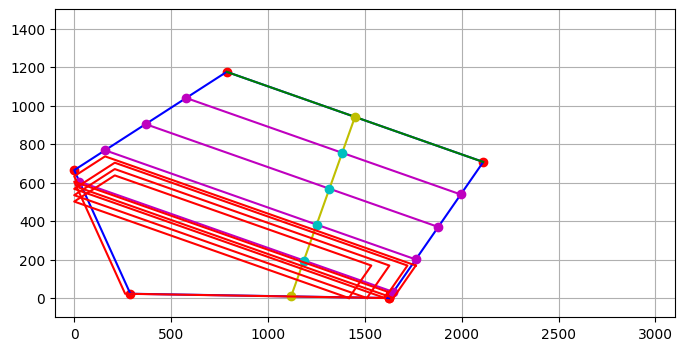

In [29]:
# plot 
plt.figure(figsize=(8,4))
plt.xlim(-100, 3100)
plt.ylim(-100, 1500)

plt.plot([x[0] for x in cartesian_coordinates], [x[1] for x in cartesian_coordinates], 'ro')
plt.plot([x[0] for x in cartesian_coordinates] + [cartesian_coordinates[0][0]], [x[1] for x in cartesian_coordinates] + [cartesian_coordinates[0][1]], 'b-')

plt.plot([x[0] for x in longest_edge_points], [x[1] for x in longest_edge_points], 'g-')

plt.plot([x[0] for x in intersection_pts_of_perpendicular_line], [x[1] for x in intersection_pts_of_perpendicular_line], 'yo')
plt.plot([x[0] for x in intersection_pts_of_perpendicular_line], [x[1] for x in intersection_pts_of_perpendicular_line], 'y-')

for points in intersection_pts_of_parallel_lines:
    plt.plot([x[0] for x in points], [x[1] for x in points], 'mo')
    plt.plot([x[0] for x in points], [x[1] for x in points], 'm-')

for point in perpendicular_points:
    plt.plot(point[0], point[1], 'co')
    
for area in final_area[:]:
    area_c = convert_to_cartesian(area)
    plt.plot([x[0] for x in area_c] + [area_c[0][0]], [x[1] for x in area_c] + [area_c[0][1]], 'r-')
    
plt.grid()